# Homework 4: The various classifiers

In [4]:
import pandas as pd

df = pd.read_csv("data/diabetes_binary_health_indicators_BRFSS2015.csv")

In [16]:
# Confirm numberic types
print(df.dtypes, '\n')

# Find if there are null values
print(df.isna().sum(), '\n')

# Check class imabalance
print(df.Diabetes_binary.value_counts())

Diabetes_binary         float64
HighBP                  float64
HighChol                float64
CholCheck               float64
BMI                     float64
Smoker                  float64
Stroke                  float64
HeartDiseaseorAttack    float64
PhysActivity            float64
Fruits                  float64
Veggies                 float64
HvyAlcoholConsump       float64
AnyHealthcare           float64
NoDocbcCost             float64
GenHlth                 float64
MentHlth                float64
PhysHlth                float64
DiffWalk                float64
Sex                     float64
Age                     float64
Education               float64
Income                  float64
dtype: object 

Diabetes_binary         0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies             

<Axes: >

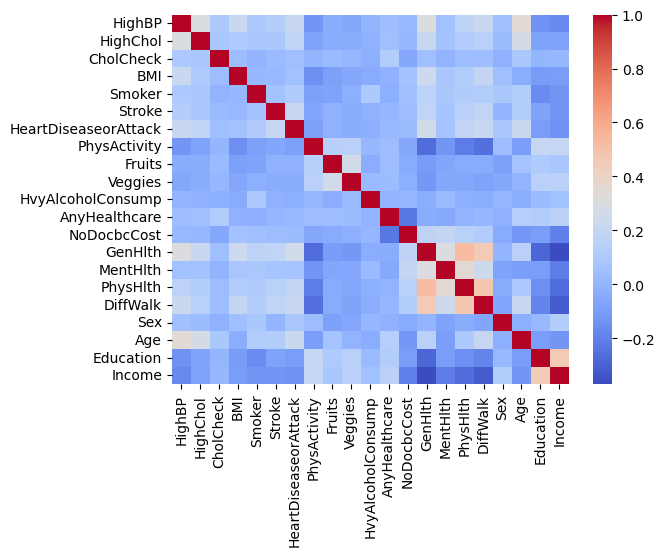

In [24]:
import seaborn as sns

# Split data set into features and target for processing
y, X = df['Diabetes_binary'], df[[col for col in df.columns if col != 'Diabetes_binary']]

corr = X.corr()
sns.heatmap(corr, cmap="coolwarm")

In [30]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create reduced dataset for models affected by multicollinearity
def compute_vifs(input_df):
    vif_df = pd.DataFrame({"feature": input_df.columns, "VIF": [
        variance_inflation_factor(X.values, feature_idx) for feature_idx in range(input_df.shape[1])
    ]})
    return vif_df

reduced_df = X.copy()

vif_df = compute_vifs(reduced_df)
while vif_df['VIF'].max() > 10: # Only accepting VIFs <= 10
    print(vif_df)
    feature_to_drop = vif_df.sort_values('VIF', ascending=False)['feature'].iloc[0]
    print(f"Dropping feature: {feature_to_drop}\n")
    reduced_df = reduced_df.drop(feature_to_drop, axis=1)
    vif_df = compute_vifs(reduced_df)


                 feature        VIF
0                 HighBP   2.299761
1               HighChol   2.029660
2              CholCheck  23.187436
3                    BMI  18.149913
4                 Smoker   1.933042
5                 Stroke   1.126777
6   HeartDiseaseorAttack   1.289820
7           PhysActivity   4.645314
8                 Fruits   3.032775
9                Veggies   5.826886
10     HvyAlcoholConsump   1.083523
11         AnyHealthcare  20.839710
12           NoDocbcCost   1.215834
13               GenHlth  10.740162
14              MentHlth   1.463103
15              PhysHlth   1.999556
16              DiffWalk   1.838551
17                   Sex   1.910708
18                   Age   9.886830
19             Education  29.507416
20                Income  14.156118
Dropping feature: Education

                 feature        VIF
0                 HighBP   2.299761
1               HighChol   2.029660
2              CholCheck  23.187436
3                    BMI  18.149913

In [29]:
reduced_df.columns

Index(['HighBP', 'HighChol'], dtype='object')

In [80]:
from sklearn.model_selection import train_test_split

# Unbalanced + not scaled
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # Stratify to split while considering imbalanced classes

from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler

# Unbalanced + scaled
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Down sample data
under_sampler = RandomUnderSampler(random_state=42)
X_down_sampled, y_down_sampled = under_sampler.fit_resample(X, y)

scaler = StandardScaler()
X_down_scaled = pd.DataFrame(scaler.fit_transform(X_down_sampled), columns=X.columns)

# Balanced + scaled
X_ds_train, X_ds_test, y_ds_train, y_ds_test = train_test_split(X_down_scaled, y_down_sampled, test_size=0.2, random_state=42)

### Data cleaning summary

The data was very complete and clean as is. There were no null values and all types are already numeric and ready for training. The primary items to be mindful of in this dataset is the imbalance of classes; there are 218,334 instances of class 0 (no diabetes) and 35,346 instances of class 1 (diabetes or pre-diabetes) and the scaling of data such as BMI. With this imbalance in mind, I created 3 train-test data sets to use amongst the classifiers: unbalanced + unscaled, unbalanced + scaled, and balanced + scaled. For the unbalanced datasets, I performed the 80/20 split using the stratify option to ensure the train and test sets preserve a similar balance of classes.

I created these datasets based on the classifier types and the options available for each classifier. If a classifier is susceptible to data imbalance I will use the SKlearn `class_weight='balanced'` option where applicable which will adjust the weights to overemphasize the minority class. If the classifier is sensitive to scale, then I will use a scaled data set.

* Logistic Regression - Unbalanced and scaled set (utilize regularization and `class_weight='balanced'`)
* kNN - Balanced and scaled (no option available to for `class_weight='balanced'`)
* Decision tree - Unbalanced and unscaled
* SVM - Unbalanced and scaled (use `class_weight='balanced'`)

Additionally, I attempted to address multicollinearity by first viewing the bivariate correlations between features. This showed few correlated features and none were too concerning, so I did not remove any features based off this analysis. I then attempted to iteratively compute the VIF of all features and remove the feature with the highest VIF until all VIFs where <= 10. Doing this ended up creating a severely reduced dataset containing only 2 features. Instead of moving forward with the reduced dataset, I will instead use regularization in my logistic model as I think the large reduction in features will likely result in too much information loss.

### Classification

In [79]:
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

LABELS = ['No Diabetes', 'Diabetes or Pre-diabetes']
def evaluate_model(y_true, y_pred):
    print(classification_report(y_true, y_pred, target_names=LABELS), '\n')
    print("accuracy_score:", accuracy_score(y_true, y_pred))
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap='Blues', display_labels=LABELS)

##### Logistic Regression

                          precision    recall  f1-score   support

             No Diabetes       0.95      0.73      0.82     43667
Diabetes or Pre-diabetes       0.31      0.76      0.44      7069

                accuracy                           0.73     50736
               macro avg       0.63      0.74      0.63     50736
            weighted avg       0.86      0.73      0.77     50736
 

accuracy_score: 0.7315121412803532


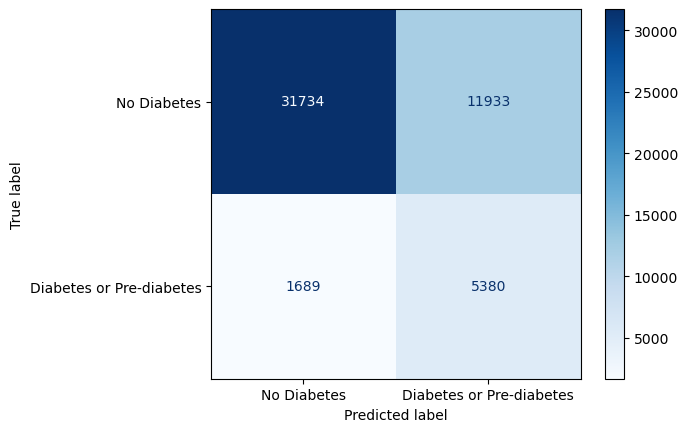

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logistic_model = LogisticRegression(penalty='l2', class_weight='balanced')
logistic_model.fit(X_train_scaled, y_train_scaled)

evaluate_model(y_test_scaled, logistic_model.predict(X_test_scaled))

In [90]:
coeff_df = pd.DataFrame(logistic_model.coef_, columns=X.columns).T
coeff_df.sort_values(0, ascending=False)

,0
GenHlth,0.618877
BMI,0.491356
Age,0.457839
HighBP,0.364272
HighChol,0.287252
CholCheck,0.246918
Sex,0.139149
HeartDiseaseorAttack,0.073029
DiffWalk,0.037369
Stroke,0.037313


##### KNN

                          precision    recall  f1-score   support

             No Diabetes       0.73      0.69      0.71      7090
Diabetes or Pre-diabetes       0.70      0.74      0.72      7049

                accuracy                           0.71     14139
               macro avg       0.71      0.71      0.71     14139
            weighted avg       0.71      0.71      0.71     14139
 

accuracy_score: 0.7141240540349388


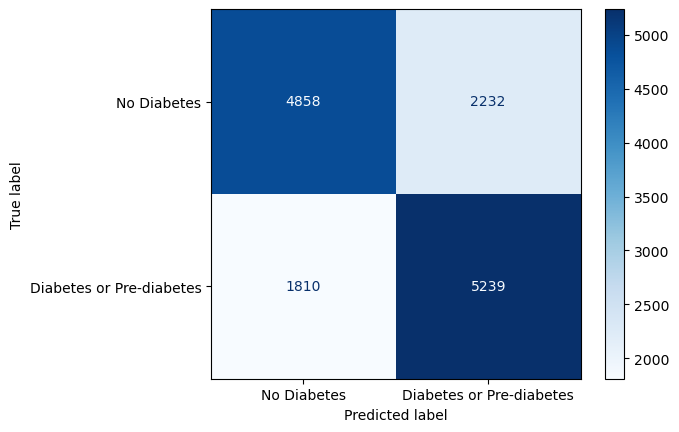

In [82]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()
knn_model.fit(X_ds_train, y_ds_train)

evaluate_model(y_ds_test, knn_model.predict(X_ds_test))

##### Decision Tree

                          precision    recall  f1-score   support

             No Diabetes       0.89      0.88      0.88     43667
Diabetes or Pre-diabetes       0.29      0.30      0.29      7069

                accuracy                           0.80     50736
               macro avg       0.59      0.59      0.59     50736
            weighted avg       0.80      0.80      0.80     50736
 

accuracy_score: 0.7983483128350678


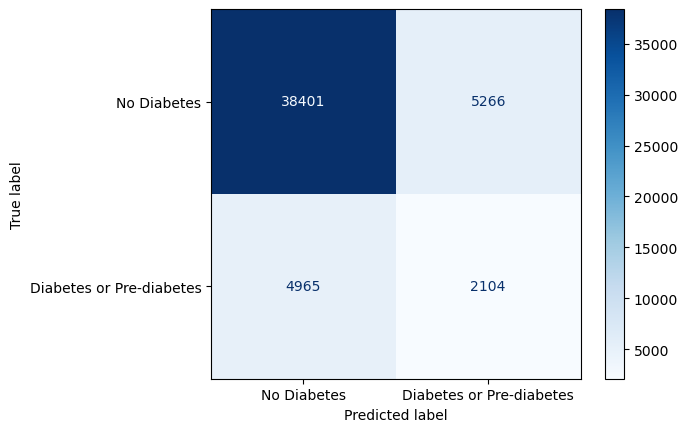

In [84]:
from sklearn.tree import DecisionTreeClassifier

tree_classifier = DecisionTreeClassifier(class_weight='balanced')
tree_classifier.fit(X_train, y_train)


evaluate_model(y_test, tree_classifier.predict(X_test))

<Axes: xlabel='importance', ylabel='feature'>

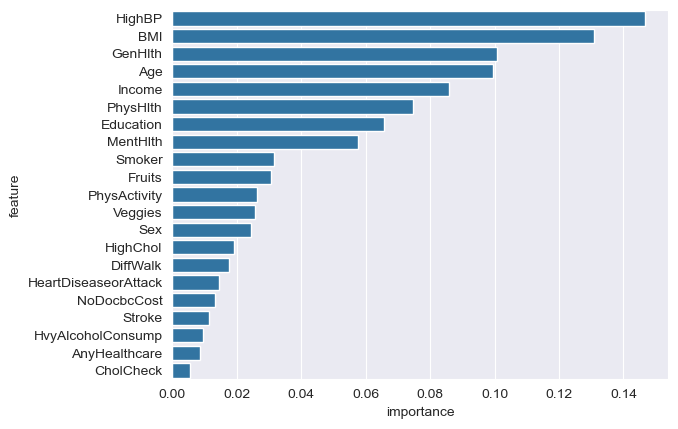

In [97]:
# Plot feature importance

importance_df = pd.DataFrame({'feature': X.columns, 'importance': tree_classifier.feature_importances_})
importance_df.sort_values(by=['importance'], ascending=False, inplace=True)
sns.barplot(x="importance", y="feature", data=importance_df, orient='h')

##### Support Vector Machine

                          precision    recall  f1-score   support

             No Diabetes       0.95      0.70      0.81     43667
Diabetes or Pre-diabetes       0.30      0.79      0.44      7069

                accuracy                           0.72     50736
               macro avg       0.63      0.75      0.62     50736
            weighted avg       0.86      0.72      0.76     50736
 

accuracy_score: 0.7154288867865026


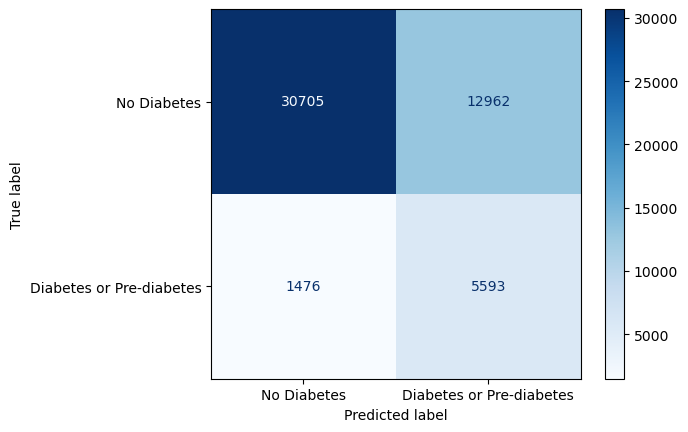

In [91]:
from sklearn.svm import SVC

scm_classifier = SVC(class_weight='balanced')
scm_classifier.fit(X_train_scaled, y_train_scaled)
evaluate_model(y_test_scaled, scm_classifier.predict(X_test_scaled))

### Summary

Model Performance:

This dataset provides the ability to predict if a person is diabetic or pre-diabetic. From an application perspective, this could be helpful in clinical workflows to notify if a patient has a high risk of being diabetic. With this in mind we would want to stay conservative in our predictions and ensure all patients that are diabetic or prediabetic are predicted to be. It's ok if we have more false positives, it's more important to ensure no patient falls through the cracks (i.e. False negatives). So, we want to have a model with high accuracy and recall. Recall will let us know how much of the actual diabetic group we predicted correctly.

Each model used cross-validation, thus the following results were measured on the test datasets:

| Model | Accuracy | Recall |
|---|----------|--------|
| Logistic regression | 0.73     | 0.76   |
| kNN | 0.71     | 0.74   |
| Decision Tree | 0.79     | 0.30   |
| SVM | 0.71     | 0.79   |

Each model preformed fairly similar with the decision tree having the highest accuracy and SVM having the highest recall. Although the decision tree had the highest accuracy, this is not the best performing model given the clinical context as its recall is very low at 0.30, meaning it performed better at predicting the non-diabetic class. The models which could be useful in the case is logistic regression and SVM. Logistic regression has a higher accuracy than SVM, but SVM has a higher recall. Both models are very close, but in this case the SVM model is the most performant as we want to optimize recall. We can take a hit on accuracy since it is more important to get patients treatment and turn some away with a false flag then to not treat patients that need it.

Model Interpretation:

The models that were easiest to interpret were logistic regression and decision trees. In the case of logistic regression, we can inspect the coefficients to get a sense of what is the most impactful feature. In this case the feature with the largest coefficient is `GenHlth`. This feature is a self reported overall score of a patient's health. For decision trees we can take a look at feature importance. The decision tree put `HighBP`, `BMI`, and then `GenHlth` as the most impactful feature.

kNN and SVM are more difficult to interpret. We can use metrics to get a sense of how well they perform, but determining feature impact/importance is not feasible. This is limiting as it reduces insight into how we can transform or alter our input dataset to aid in improving predictions.

Model scaling:

I believe the logistic regression model would scale the best with more data. The training time is linear and the prediction time is constant. Given that logistic regression performed closely to the SVM, choosing logistic regression over SVM could be good in a production scenario. Although SVM performed better than logistic regression, the training time is cubic and the prediction time depends on the number of support vectors which could increase as more data.

Data Challenges:

This dataset was very clean and could nearly be used for training out of the box. The primary challenges I faced with this dataset is knowing if a feature should be scaled and if the dataset should be balanced for a given classifier. This dataset was full of likert scale-like features (e.g. always = 5, never = 0). Understanding if scaling was typically used in these scenarios took a fair amount of research. Thanks to tooling, `imbalance-learn` along with weight adjustment in SKlearn, handling the dataset imbalance was simple.

